## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_conv04']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day', 'temp_initial00'] #,  
               #  'buoyancy', 'diffusivity', 'temp_initial00', 
               # 'temp_heat01', 'temp_diff02', 'temp_total05',
               # 'ice', 'snow', 'snowice'
m0_output_columns =['temp_conv04']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./saved_models/directdeep_model_PB_finetuned.pth"
m0_layers = [len(m0_input_columns), 32, 32,32,32,32,32,32,32,32,32, len(m0_output_columns)]

direct_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
direct_model.load_state_dict(m0_checkpoint)
direct_model = direct_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

## Mixing Model

# Convection Model

# Ice Model

In [9]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [10]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [11]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [12]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [13]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [14]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [15]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [16]:
def get_rollout_predictions(direct_model, loader, plot = True):    
    direct_model.eval()

    mean = torch.tensor(train_mean[m0_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m0_output_column_ix]).float().to(device)


#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        y_true = x[:, m0_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m0_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [17]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [18]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 4.1038327
RMSE of after m0 4.2733207
RMSE of after m0 4.7877502
RMSE of after m0 4.543032
RMSE of after m0 4.6211033
RMSE of after m0 4.688069
RMSE of after m0 4.6749234
RMSE of after m0 4.6419516
RMSE of after m0 4.5275908
RMSE of after m0 4.5725107
RMSE of after m0 4.4759135
RMSE of after m0 4.560718
RMSE of after m0 4.6635756
RMSE of after m0 4.6237874
RMSE of after m0 4.4718895
RMSE of after m0 4.403025
RMSE of after m0 4.3108006
RMSE of after m0 4.092612
RMSE of after m0 4.09397
RMSE of after m0 4.2948017
RMSE of after m0 4.120412
RMSE of after m0 4.0137734
RMSE of after m0 3.9818141
RMSE of after m0 4.043922
RMSE of after m0 3.7720196
RMSE of after m0 3.6617827
RMSE of after m0 3.7135978
RMSE of after m0 4.0147243
RMSE of after m0 3.7152126
RMSE of after m0 3.6758702
RMSE of after m0 3.5364523
RMSE of after m0 3.4581974
RMSE of after m0 3.409149
RMSE of after m0 3.410184
RMSE of after m0 3.4285078
RMSE of after m0 3.3356063
RMSE of after m0 3.3274171
RMSE of afte

RMSE of after m0 7.9875665
RMSE of after m0 8.173991
RMSE of after m0 8.344882
RMSE of after m0 8.545019
RMSE of after m0 8.850829
RMSE of after m0 8.818063
RMSE of after m0 8.58244
RMSE of after m0 8.592184
RMSE of after m0 8.562597
RMSE of after m0 8.531087
RMSE of after m0 8.446025
RMSE of after m0 8.354777
RMSE of after m0 8.28243
RMSE of after m0 8.237604
RMSE of after m0 8.091967
RMSE of after m0 7.993144
RMSE of after m0 7.9261646
RMSE of after m0 7.9536495
RMSE of after m0 8.45987
RMSE of after m0 9.428207
RMSE of after m0 9.477283
RMSE of after m0 9.6966505
RMSE of after m0 10.463808
RMSE of after m0 9.871078
RMSE of after m0 10.118053
RMSE of after m0 10.239818
RMSE of after m0 10.017509
RMSE of after m0 10.048829
RMSE of after m0 9.509621
RMSE of after m0 8.728884
RMSE of after m0 8.491735
RMSE of after m0 8.342805
RMSE of after m0 7.987401
RMSE of after m0 7.8436594
RMSE of after m0 8.011761
RMSE of after m0 7.9371076
RMSE of after m0 7.8525953
RMSE of after m0 7.763
RMSE o

RMSE of after m0 4.088461
RMSE of after m0 4.3194165
RMSE of after m0 4.3971844
RMSE of after m0 4.4486265
RMSE of after m0 4.5022454
RMSE of after m0 4.535897
RMSE of after m0 4.671285
RMSE of after m0 4.507533
RMSE of after m0 4.4284363
RMSE of after m0 4.4749107
RMSE of after m0 4.46977
RMSE of after m0 4.512536
RMSE of after m0 4.471856
RMSE of after m0 4.58369
RMSE of after m0 4.594271
RMSE of after m0 4.5135164
RMSE of after m0 4.5879736
RMSE of after m0 4.6869035
RMSE of after m0 4.760559
RMSE of after m0 4.897774
RMSE of after m0 4.954058
RMSE of after m0 4.948697
RMSE of after m0 4.8432546
RMSE of after m0 4.8588114
RMSE of after m0 4.793235
RMSE of after m0 4.7551985
RMSE of after m0 4.7953224
RMSE of after m0 4.733698
RMSE of after m0 4.887383
RMSE of after m0 4.921272
RMSE of after m0 4.9946685
RMSE of after m0 5.1968575
RMSE of after m0 5.317916
RMSE of after m0 5.4281635
RMSE of after m0 5.310065
RMSE of after m0 5.303517
RMSE of after m0 5.4027724
RMSE of after m0 5.4356

RMSE of after m0 1.0301147
RMSE of after m0 1.0181804
RMSE of after m0 1.1968784
RMSE of after m0 1.2055533
RMSE of after m0 1.0525792
RMSE of after m0 1.0770773
RMSE of after m0 1.1689216
RMSE of after m0 1.0775387
RMSE of after m0 1.0375897
RMSE of after m0 1.0599589
RMSE of after m0 1.1750379
RMSE of after m0 1.106731
RMSE of after m0 1.0346678
RMSE of after m0 1.1450974
RMSE of after m0 1.1211358
RMSE of after m0 1.2082614
RMSE of after m0 1.2941675
RMSE of after m0 1.1691366
RMSE of after m0 1.2046936
RMSE of after m0 1.2405896
RMSE of after m0 1.2290535
RMSE of after m0 1.3145503
RMSE of after m0 1.3468896
RMSE of after m0 1.3355097
RMSE of after m0 1.2915189
RMSE of after m0 1.5247637
RMSE of after m0 1.4518431
RMSE of after m0 1.4176673
RMSE of after m0 1.4291846
RMSE of after m0 1.5291098
RMSE of after m0 1.533123
RMSE of after m0 1.7828543
RMSE of after m0 1.7636957
RMSE of after m0 1.7435971
RMSE of after m0 1.6401131
RMSE of after m0 1.8280444
RMSE of after m0 2.0435648
RMS

RMSE of after m0 5.79434
RMSE of after m0 5.9832873
RMSE of after m0 5.9844995
RMSE of after m0 5.502051
RMSE of after m0 6.7309456
RMSE of after m0 5.861852
RMSE of after m0 5.023088
RMSE of after m0 4.7979307
RMSE of after m0 5.927342
RMSE of after m0 6.188993
RMSE of after m0 5.3567414
RMSE of after m0 5.4781404
RMSE of after m0 5.3129
RMSE of after m0 4.6113257
RMSE of after m0 4.500616
RMSE of after m0 4.914094
RMSE of after m0 4.6846194
RMSE of after m0 4.4733787
RMSE of after m0 4.729794
RMSE of after m0 4.8680506
RMSE of after m0 4.752631
RMSE of after m0 4.706613
RMSE of after m0 4.6108727
RMSE of after m0 4.4253683
RMSE of after m0 4.1951785
RMSE of after m0 4.0409846
RMSE of after m0 4.0762095
RMSE of after m0 4.075197
RMSE of after m0 3.8364534
RMSE of after m0 4.0772943
RMSE of after m0 4.166308
RMSE of after m0 4.2629566
RMSE of after m0 4.3400955
RMSE of after m0 4.341545
RMSE of after m0 4.3657475
RMSE of after m0 4.5256104
RMSE of after m0 4.297412
RMSE of after m0 4.0

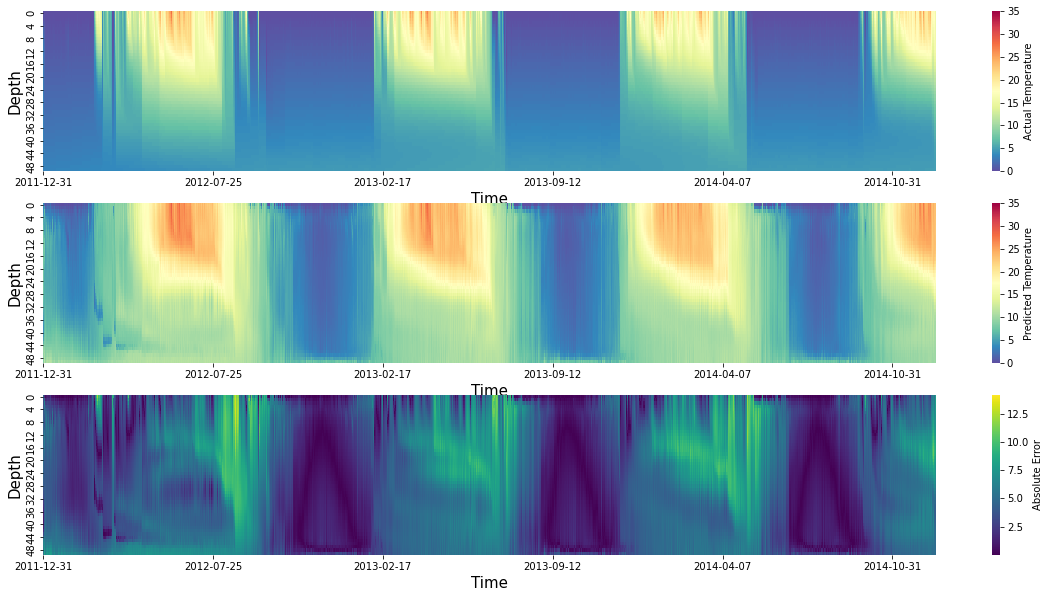

In [19]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

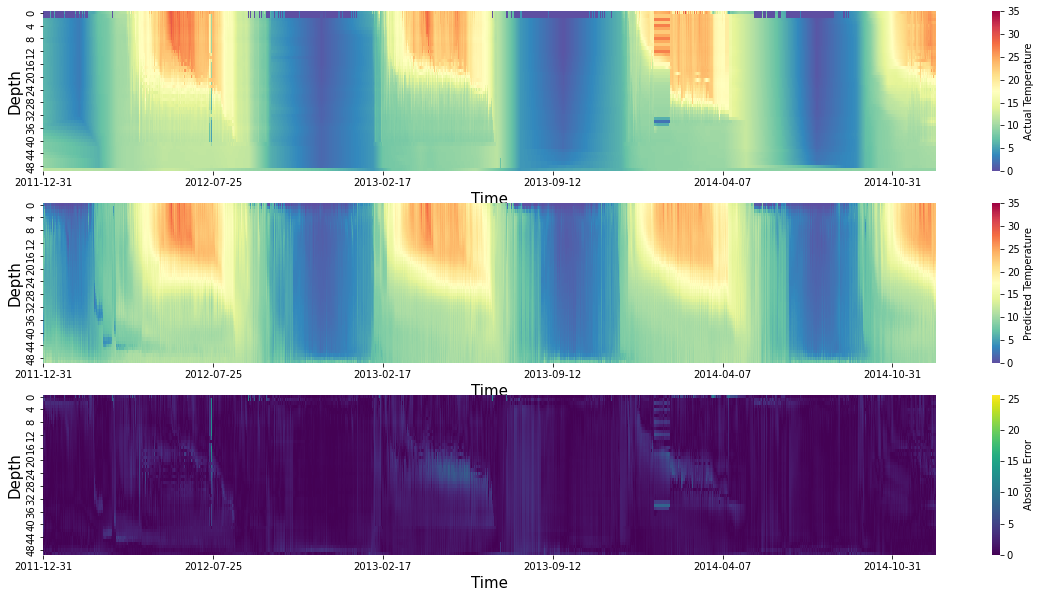

In [20]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [21]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 6.731235
RMSE of after m0 6.7304487
RMSE of after m0 6.5420628
RMSE of after m0 6.4849057
RMSE of after m0 6.4987583
RMSE of after m0 6.5334597
RMSE of after m0 6.4767127
RMSE of after m0 6.425766
RMSE of after m0 6.56346
RMSE of after m0 6.758475
RMSE of after m0 6.622445
RMSE of after m0 6.5108023
RMSE of after m0 6.6614037
RMSE of after m0 6.3926253
RMSE of after m0 6.2420244
RMSE of after m0 6.4383116
RMSE of after m0 6.6766663
RMSE of after m0 6.988182
RMSE of after m0 7.1469517
RMSE of after m0 7.1211596
RMSE of after m0 7.0575156
RMSE of after m0 7.1608334
RMSE of after m0 7.7752357
RMSE of after m0 7.8155704
RMSE of after m0 7.5740128
RMSE of after m0 7.5307035
RMSE of after m0 7.5933995
RMSE of after m0 7.4555664
RMSE of after m0 7.2083063
RMSE of after m0 7.147382
RMSE of after m0 7.211025
RMSE of after m0 7.07843
RMSE of after m0 6.860547
RMSE of after m0 6.720729
RMSE of after m0 6.5536776
RMSE of after m0 6.5389237
RMSE of after m0 6.58813
RMSE of after m0

RMSE of after m0 3.192301
RMSE of after m0 3.1957266
RMSE of after m0 3.1435423
RMSE of after m0 3.118741
RMSE of after m0 3.3180203
RMSE of after m0 3.3289526
RMSE of after m0 3.4046288
RMSE of after m0 3.6530273
RMSE of after m0 4.210054
RMSE of after m0 4.183018
RMSE of after m0 4.040545
RMSE of after m0 4.1276603
RMSE of after m0 4.256129
RMSE of after m0 4.3098593
RMSE of after m0 4.3899317
RMSE of after m0 4.497259
RMSE of after m0 4.589059
RMSE of after m0 4.5902877
RMSE of after m0 4.5651994
RMSE of after m0 4.34715
RMSE of after m0 4.4470115
RMSE of after m0 4.5408673
RMSE of after m0 4.587878
RMSE of after m0 4.548166
RMSE of after m0 4.5792603
RMSE of after m0 4.4849753
RMSE of after m0 4.4227424
RMSE of after m0 4.6213126
RMSE of after m0 4.558083
RMSE of after m0 4.7095118
RMSE of after m0 4.64956
RMSE of after m0 4.6975703
RMSE of after m0 4.8270254
RMSE of after m0 4.881553
RMSE of after m0 5.058426
RMSE of after m0 5.1739597
RMSE of after m0 5.2823653
RMSE of after m0 5

RMSE of after m0 1.0366783
RMSE of after m0 1.0341336
RMSE of after m0 1.0434808
RMSE of after m0 1.1312983
RMSE of after m0 1.1544329
RMSE of after m0 1.0352542
RMSE of after m0 1.0184263
RMSE of after m0 1.1771818
RMSE of after m0 1.2196066
RMSE of after m0 1.2647476
RMSE of after m0 1.2849301
RMSE of after m0 1.2962083
RMSE of after m0 1.2871264
RMSE of after m0 1.2487751
RMSE of after m0 1.2493602
RMSE of after m0 1.2651212
RMSE of after m0 1.3416528
RMSE of after m0 1.3658774
RMSE of after m0 1.3662889
RMSE of after m0 1.5137209
RMSE of after m0 1.5417556
RMSE of after m0 1.4363179
RMSE of after m0 1.5330771
RMSE of after m0 1.3153154
RMSE of after m0 1.1671222
RMSE of after m0 1.1114458
RMSE of after m0 1.1068627
RMSE of after m0 1.0945244
RMSE of after m0 1.1904728
RMSE of after m0 1.3536912
RMSE of after m0 1.1413449
RMSE of after m0 1.0680033
RMSE of after m0 1.0333078
RMSE of after m0 1.0009522
RMSE of after m0 1.1384983
RMSE of after m0 1.4257778
RMSE of after m0 2.0702782
R

RMSE of after m0 8.58258
RMSE of after m0 8.564456
RMSE of after m0 8.178887
RMSE of after m0 7.864296
RMSE of after m0 7.850379
RMSE of after m0 7.7849
RMSE of after m0 7.4133472
RMSE of after m0 7.466626
RMSE of after m0 7.8888927
RMSE of after m0 7.572095
RMSE of after m0 7.557206
RMSE of after m0 7.363718
RMSE of after m0 7.0151052
RMSE of after m0 7.058083
RMSE of after m0 7.327197
RMSE of after m0 7.0643115
RMSE of after m0 6.706835
RMSE of after m0 6.8155193
RMSE of after m0 6.6784286
RMSE of after m0 6.3990326
RMSE of after m0 6.2325015
RMSE of after m0 6.1751537
RMSE of after m0 6.178096
RMSE of after m0 6.061102
RMSE of after m0 5.754125
RMSE of after m0 5.6351023
RMSE of after m0 5.682338
RMSE of after m0 5.3908997
RMSE of after m0 5.2842197
RMSE of after m0 5.0203524
RMSE of after m0 4.98093
RMSE of after m0 4.811201
RMSE of after m0 4.6500974
RMSE of after m0 4.5808525
RMSE of after m0 4.436752
RMSE of after m0 4.32022
RMSE of after m0 4.2242513
RMSE of after m0 4.0586524


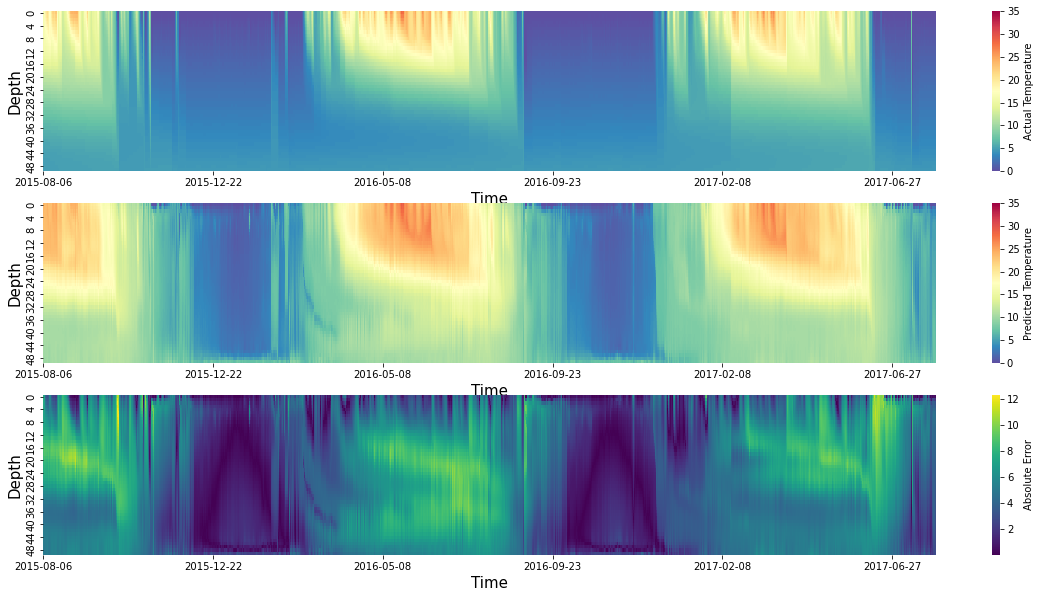

In [22]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

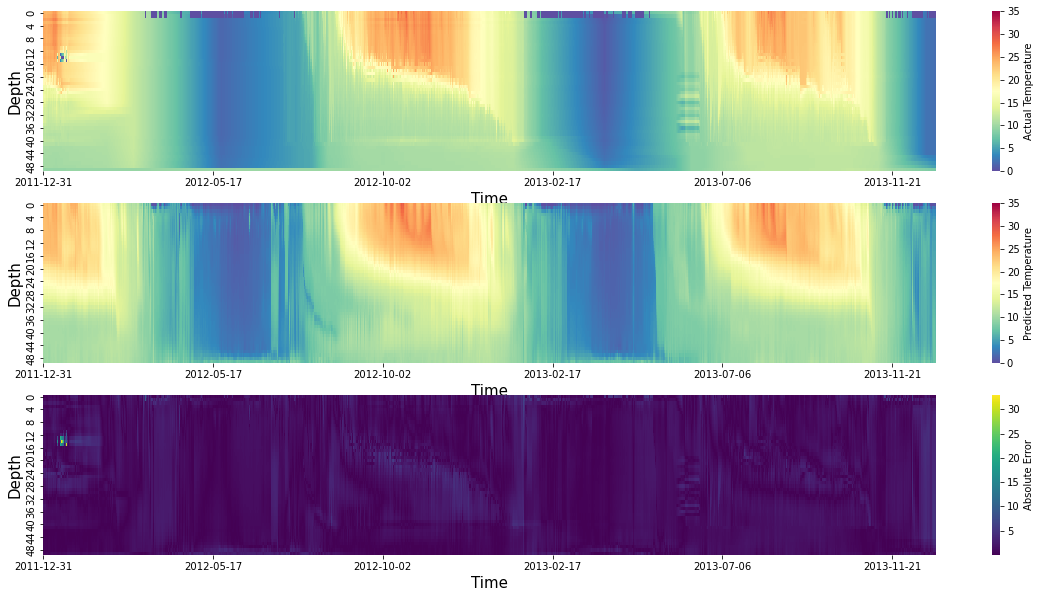

In [23]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [24]:
train_rmse, train_l2_err = compute_metrics( direct_model, train_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(direct_model, test_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.88555235751894, Train L2 Error: 0.6433906459295052
Test RMSE: 5.169018073009132, Train L2 Error: 0.6498595616451704


## Mixing Model

## Convection Model

## Ice Model

In [25]:
def plot_output_test(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)


    sns.heatmap(y_pred.T, ax=ax, cmap='Spectral_r', vmin=0., vmax=35.)
    ax.set_ylabel("Depth (m)", fontsize=15)
    ax.set_xlabel("Time", fontsize=15)
    ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax.set_xticklabels(time_label, rotation=0)
    ax.collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)")
    yticks_ix = np.array(ax.get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax.set_yticklabels(depth_label, rotation=0)

    plt.show()

# Finetuning

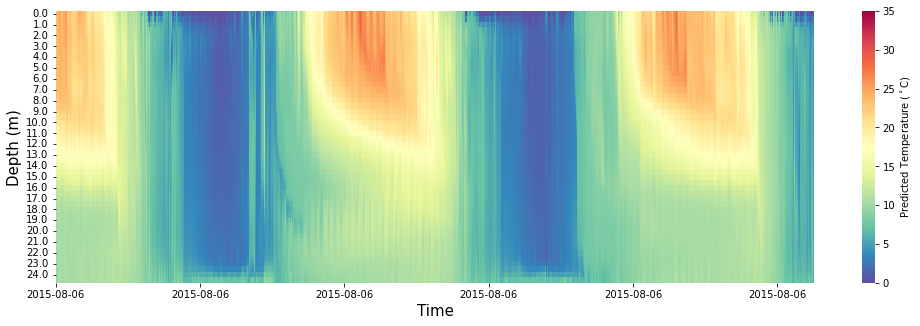

In [26]:
plot_output_test(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(17,5))